In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
nltk.download('punkt', download_dir=os.path.expanduser('~/nltk_data'))
nltk.download('stopwords', download_dir=os.path.expanduser('~/nltk_data'))
nltk.download('vader_lexicon', download_dir=os.path.expanduser('~/nltk_data'))
nltk.download('punkt_tab', download_dir=os.path.expanduser('~/nltk_data'))

from src.data_loader import find_data_dir, load_data, clean_html

[nltk_data] Downloading package punkt to C:\Users\jacka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jacka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jacka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load data

In [3]:
data_dir = find_data_dir()
csv_path = os.path.join(data_dir, "raw", "IMDB Dataset.csv")
df = pd.read_csv(csv_path)

## Exploratory data analysis

#### Look at the dataset structure

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# Missing values
df.isnull().sum()


review       0
sentiment    0
dtype: int64

In [8]:
# Empty or whitespace-only reviews
df['empty_review'] = df['review'].str.strip().eq('')
df['empty_review'].sum()


np.int64(0)

In [9]:
# Duplicate reviews
df.duplicated(subset='review').sum()


np.int64(418)

Observation - It is a relatively balance dataset with total 50K rows split evenly between positive and negative reviews (25K each). There are no null values and empty reviews, but there are ~420 duplicate reviews

In [10]:
df['char_count'] = df['review'].str.len()
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df[['char_count', 'word_count']].describe()

,char_count,word_count
count,50000.000000,50000.000000
mean,1309.431020,231.156940
std,989.728014,171.343997
min,32.000000,4.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.250000,280.000000
max,13704.000000,2470.000000


In [11]:
(df[['char_count', 'word_count']]
 .groupby(df['sentiment'])
 .describe().T)

sentiment             negative      positive
char_count count  25000.000000  25000.000000
           mean    1294.064360   1324.797680
           std      945.892669   1031.492627
           min       32.000000     65.000000
           25%      706.000000    691.000000
           50%      973.000000    968.000000
           75%     1567.250000   1614.000000
           max     8969.000000  13704.000000
word_count count  25000.000000  25000.000000
           mean     229.464560    232.849320
           std      164.947795    177.497046
           min        4.000000     10.000000
           25%      128.000000    125.000000
           50%      174.000000    172.000000
           75%      278.000000    284.000000
           max     1522.000000   2470.000000

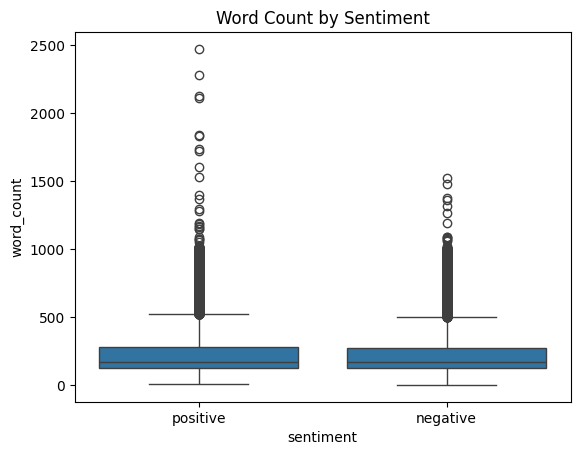

In [12]:
plt.figure()
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title("Word Count by Sentiment")
plt.show()


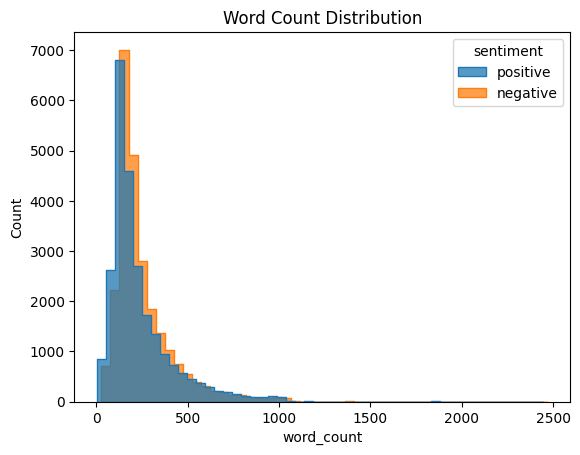

In [13]:
plt.figure()
sns.histplot(df,x='word_count', bins=50, 
             hue='sentiment', element="step",
             multiple="dodge",
             )
plt.title("Word Count Distribution")
plt.show()


In [14]:
df['clean_review'] = df['review'].apply(clean_html)

In [15]:
# stop_words = set(stopwords.words('english'))

# def get_tokens(text):
#     return word_tokenize(text.lower())

# # tokens = df['clean_review'].apply(get_tokens)


In [16]:
df.head()

,review,sentiment,empty_review,char_count,word_count,clean_review
0,One of the other reviewers has mentioned that ...,positive,False,1761,307,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,False,998,162,a wonderful little production. the filming t...
2,I thought this was a wonderful way to spend ti...,positive,False,926,166,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,False,748,138,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,False,1317,230,"petter mattei's ""love in the time of money"" is..."


In [17]:
#N grams analysis

vectorizer = CountVectorizer(
    ngram_range=(2,2),
    min_df=5,
    stop_words='english'
)

X_bigrams = vectorizer.fit_transform(df['clean_review'])

bigram_freq = np.asarray(X_bigrams.sum(axis=0)).flatten()
bigrams = vectorizer.get_feature_names_out()

top_bigrams = sorted(
    zip(bigrams, bigram_freq),
    key=lambda x: x[1],
    reverse=True
)[:20]

top_bigrams


[('ve seen', np.int64(4168)),
 ('special effects', np.int64(2249)),
 ('don know', np.int64(2202)),
 ('low budget', np.int64(1824)),
 ('looks like', np.int64(1678)),
 ('year old', np.int64(1598)),
 ('movie just', np.int64(1538)),
 ('waste time', np.int64(1526)),
 ('good movie', np.int64(1515)),
 ('sci fi', np.int64(1393)),
 ('watch movie', np.int64(1377)),
 ('new york', np.int64(1316)),
 ('look like', np.int64(1312)),
 ('don think', np.int64(1305)),
 ('years ago', np.int64(1256)),
 ('real life', np.int64(1240)),
 ('high school', np.int64(1164)),
 ('main character', np.int64(1140)),
 ('pretty good', np.int64(1120)),
 ('movie like', np.int64(1087))]

In [18]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(df['clean_review'])

feature_names = tfidf.get_feature_names_out()
idf_scores = tfidf.idf_

top_tfidf = sorted(
    zip(feature_names, idf_scores),
    key=lambda x: x[1],
    reverse=True
)[:20]

top_tfidf


[('001', np.float64(10.028038814982231)),
 ('007 movie', np.float64(10.028038814982231)),
 ('10 actors', np.float64(10.028038814982231)),
 ('10 big', np.float64(10.028038814982231)),
 ('10 brilliant', np.float64(10.028038814982231)),
 ('10 character', np.float64(10.028038814982231)),
 ('10 characters', np.float64(10.028038814982231)),
 ('10 day', np.float64(10.028038814982231)),
 ('10 doesn', np.float64(10.028038814982231)),
 ('10 doubt', np.float64(10.028038814982231)),
 ('10 ending', np.float64(10.028038814982231)),
 ('10 fans', np.float64(10.028038814982231)),
 ('10 feel', np.float64(10.028038814982231)),
 ('10 gets', np.float64(10.028038814982231)),
 ('10 guess', np.float64(10.028038814982231)),
 ('10 http', np.float64(10.028038814982231)),
 ('10 loved', np.float64(10.028038814982231)),
 ('10 low', np.float64(10.028038814982231)),
 ('10 lower', np.float64(10.028038814982231)),
 ('10 mainly', np.float64(10.028038814982231))]

In [19]:
#Train, validation, test split

from sklearn.model_selection import train_test_split

X = df["clean_review"]
y = (df["sentiment"]=="positive").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 40000
Test set size: 10000


In [20]:
import joblib

data_dir = find_data_dir()
processed_path = os.path.join(data_dir, "processed")

# Save data using joblib
joblib.dump(X_train, os.path.join(processed_path, "X_train.pkl"))
joblib.dump(X_test, os.path.join(processed_path, "X_test.pkl"))
joblib.dump(y_train, os.path.join(processed_path, "y_train.pkl"))
joblib.dump(y_test, os.path.join(processed_path, "y_test.pkl"))

['c:\\jack\\study\\e2eprojects\\movie_sentiment_analysis\\data\\processed\\y_test.pkl']

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)
print(f"TF-IDF Train shape: {X_train_tfidf.shape}")
print(f"TF-IDF Test shape: {X_test_tfidf.shape}")

TF-IDF Train shape: (40000, 20000)
TF-IDF Test shape: (10000, 20000)


In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = lr.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9006
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



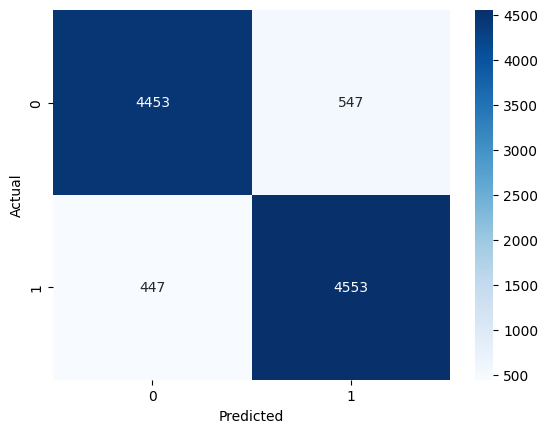

In [24]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [25]:
feature_names = tfidf.get_feature_names_out()
coef = lr.coef_[0]

top_pos = sorted(zip(coef, feature_names), reverse=True)[:20]
top_neg = sorted(zip(coef, feature_names))[:20]

top_pos, top_neg


([(np.float64(7.886417017464794), 'great'),
  (np.float64(7.041117918945845), 'excellent'),
  (np.float64(5.779067121254286), 'best'),
  (np.float64(5.44999536891106), 'perfect'),
  (np.float64(5.147841551719062), 'amazing'),
  (np.float64(5.133865542658945), 'wonderful'),
  (np.float64(4.591002816006774), 'loved'),
  (np.float64(4.40523329173247), 'fun'),
  (np.float64(4.353323725001793), 'hilarious'),
  (np.float64(4.320747885841462), 'favorite'),
  (np.float64(4.31759243385016), 'brilliant'),
  (np.float64(4.269893750258355), 'enjoyed'),
  (np.float64(4.027354854640078), 'today'),
  (np.float64(3.833787891222368), 'superb'),
  (np.float64(3.819810336903525), 'love'),
  (np.float64(3.7107395378639287), 'fantastic'),
  (np.float64(3.684439630617222), 'enjoyable'),
  (np.float64(3.634889309580937), 'definitely'),
  (np.float64(3.585174880541504), 'highly'),
  (np.float64(3.5276547674080527), '10 10')],
 [(np.float64(-9.920106418678886), 'worst'),
  (np.float64(-8.424348439510025), 'bad

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"]
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)
print("Best parameters:", grid.best_params_)
best_lr = grid.best_estimator_
accuracy_score(y_test, best_lr.predict(X_test_tfidf))



Best parameters: {'C': 10, 'penalty': 'l2'}


0.9006

Tree Based models

In [27]:
tfidf_tree = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=10,
    stop_words="english"
)

X_train_tree = tfidf_tree.fit_transform(X_train)
X_test_tree  = tfidf_tree.transform(X_test)


In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_tree, y_train)
y_pred_rf = rf.predict(X_test_tree)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.8451


In [29]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

xgb.fit(X_train_tree, y_train)
y_pred_xgb = xgb.predict(X_test_tree)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Test Accuracy: 0.8635


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_xgb = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,1),
    min_df=10,
    stop_words="english"
)

X_train_xgb = tfidf_xgb.fit_transform(X_train)
X_test_xgb  = tfidf_xgb.transform(X_test)

In [31]:
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    tree_method='hist'
)

param_dist = {
    "n_estimators": [100, 150, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 5, 10]
}

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=15,
    scoring="f1",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_xgb, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'min_child_weight': [1, 3, ...], ...}"
,n_iter,15
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [32]:
y_pred_xgb_rs = random_search.predict(X_test_xgb)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb_rs))

XGBoost Test Accuracy: 0.8477


In [33]:
import os
import pickle
import joblib  


repo_root = os.path.dirname(find_data_dir())  # go up from 'data' to repo root
models_dir = os.path.join(repo_root, "models")

# Create models folder if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Save models using joblib
joblib.dump(best_lr, os.path.join(models_dir, "logistic_regression.pkl"))

['c:\\jack\\study\\e2eprojects\\movie_sentiment_analysis\\models\\logistic_regression.pkl']